# Bayes Classifier - Credit Card Default Dataset

### Personal Notes

#### Sources
- Credit card fraud dataset : https://www.kaggle.com/dalpozz/creditcardfraud
- Credit card default payment dataset : https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset
- BayesPy library : http://www.bayespy.org/user_guide/install.html#installing-bayespy (only for Python 3)
- For Random forest implementation, see : https://www.kaggle.com/moscolitos/exploratory-data-analysis/code
- Source for VEDA : https://www.kaggle.com/mahyar511/payment-default-prediction-neural-network
- Gaussian Naive Bayes : http://dataaspirant.com/2017/02/20/gaussian-naive-bayes-classifier-implementation-python/ (sklearn)
- Sklearn Naive bayes API : http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
- Source for AUC : http://fastml.com/what-you-wanted-to-know-about-auc/

#### Improvement ideas for the project
- In the report, evaluate each classifier and make a choice on the best model (https://www.youtube.com/watch?v=85dtiMz9tSo)
    * confusion matrix
    * changing classification threshold (usually from 1-50% class A, from 51-100% class B, here the threshold is 50%)
    * ROC curve
    * AUC curve VS. log-likelihood
- Use K-fold cross validation instead of just test/train ?
- Check if it's possible (and relevant) to reduce the dimensionality of the dataset ?
- t-SNE data visualisation ? (https://www.kaggle.com/benjaminlott/credit-card-ml-rpart-xgboost-tsne-attempts?scriptVersionId=546433, https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)
- K-S (Kolmogorov-Smirnov) important model evaluation metric used in financial risk (http://chem-eng.utoronto.ca/~datamining/dmc/model_evaluation_c.htm)

#### Questions to ask
- One of the suggestion for the report was to mix the default and fraud credit card dataset. How can we manage to do that ?



### Report organization suggestion

#### Part 1 Default credit card analysis

##### 1.1 Data presentation

###### 1.1.1 Number of class, class description, % of each class

###### 1.1.2 Number of features, features description, VEDA

##### 1.2 Training and testing models (with and without throwing away data to make the set more balance)

###### 1.2.1 Bayes classifier

###### 1.2.2 Random forest classifier

###### 1.2.3 MLP

##### 1.3  Models evaluation

###### 1.3.1 Metrics KS, ROC, AUC... presentation and justification

###### 1.3.2 Model's Improvement suggestions

##### 1.4  Conclusion : which model we should choose at the end, with wich improvements

#### Part 2 Fraud credit card analysis

##### 2.1 Data presentation

###### 2.1.1 Number of class, class description, % of each class

###### 2.1.2 Number of features, features description, VEDA?

##### 2.2 Training and testing models (with and without throwing away data to make the set more balance)

###### 2.2.1 Bayes classifier

###### 2.2.2 Random forest classifier

###### 2.2.3 MLP

##### 2.3 Models evaluation

###### 2.3.1 Metrics (KS, ROC, AUC...) presentation and justification

###### 2.3.2 Model's Improvement suggestions

##### 2.4 Conclusion

#### Part 3 Mixing datasets 

### 0- Libraries importation

In [93]:
import numpy as np
import pandas
import itertools
from scipy import interp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

### 1- Basic informations on data

In [2]:
## IMPORTING DATASET ##
## source: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/data ##
data = pandas.read_csv('UCI_Credit_Card.csv')

print('------ Basic informations on dataset ------')
print data['default.payment.next.month'].value_counts() # ouput number of 0 class and number of 1 class
data.info()
# print data.describe()

------ Basic informations on dataset ------
0    23364
1     6636
Name: default.payment.next.month, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_

### 2- Visual Exploratory Data Analysis

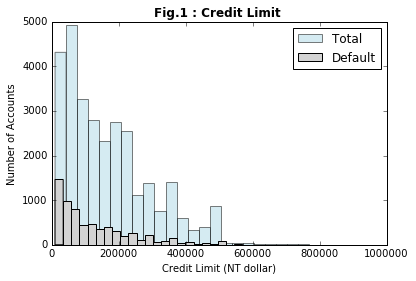

In [3]:
# Credit Limit (Feature name : 'LIMIT_BAL')
bins = 30
plt.hist(data.LIMIT_BAL, bins = bins, color='lightblue',label = 'Total',alpha=0.5)
plt.hist(data.LIMIT_BAL[data['default.payment.next.month'] == 1], bins = bins, color='lightgray',label = 'Default')

plt.xlabel('Credit Limit (NT dollar)');plt.ylabel('Number of Accounts')
plt.title('Fig.1 : Credit Limit ',fontweight="bold", size=12)
plt.legend();plt.show()

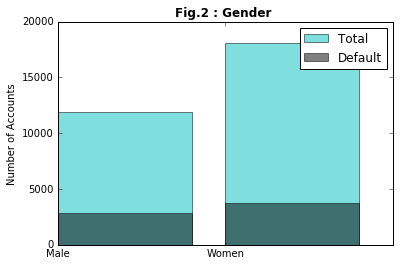

In [4]:
# Gender (Feature name : 'SEX')
men = data['SEX'][data['SEX']==1].count()
men_default = data['SEX'][(data['SEX']==1)&(data['default.payment.next.month']==1)].count()

women = data['SEX'][data['SEX']==2].count()
women_default = data['SEX'][(data['SEX']==2)&(data['default.payment.next.month']==1)].count()

total_sex = [men, women]
default_sex = [men_default,women_default]
gender = [1,2]
plt.bar(gender,total_sex, color='c',alpha=0.5, label='Total')
plt.bar(gender,default_sex, color='k',alpha=0.5, label='Default')

plt.xticks([1,2],['Male','Women']);plt.ylabel('Number of Accounts')
plt.title('Fig.2 : Gender ',fontweight="bold", size=12)
plt.legend();plt.show()

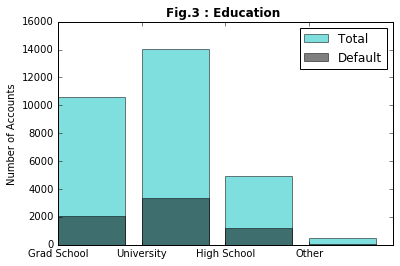

In [5]:
# Education (Feature name :'EDUCATION' )
grad =  data['EDUCATION'][data['EDUCATION']==1].count()
grad_default = data['EDUCATION'][(data['EDUCATION']==1)&(data['default.payment.next.month']==1)].count()

uni =  data['EDUCATION'][data['EDUCATION']==2].count()
uni_default = data['EDUCATION'][(data['EDUCATION']==2)&(data['default.payment.next.month']==1)].count()

high =  data['EDUCATION'][data['EDUCATION']==3].count()
high_default = data['EDUCATION'][(data['EDUCATION']==3)&(data['default.payment.next.month']==1)].count()

other =  data['EDUCATION'][data['EDUCATION'] > 3].count()
other_default = data['EDUCATION'][(data['EDUCATION'] > 3)&(data['default.payment.next.month']==1)].count()

total_education = [grad, uni, high, other]
default_education = [grad_default,uni_default,high_default, other_default]
degree = [1,2,3,4]
plt.bar(degree,total_education, color='c',alpha=0.5, label='Total')
plt.bar(degree,default_education, color='k',alpha=0.5, label='Default')

plt.xticks([1,2,3,4],['Grad School','University','High School','Other'])
plt.ylabel('Number of Accounts');plt.title('Fig.3 : Education ',fontweight="bold", size=12)
plt.legend();plt.show()

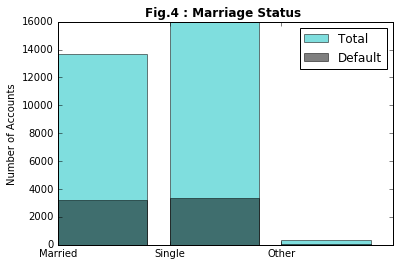

In [6]:
# Marriage Status (Feature name :'MARRIAGE')
married =  data['MARRIAGE'][data['MARRIAGE']==1].count()
married_default = data['MARRIAGE'][(data['MARRIAGE']==1)&(data['default.payment.next.month']==1)].count()

single =  data['MARRIAGE'][data['MARRIAGE']==2].count()
single_default = data['MARRIAGE'][(data['MARRIAGE']==2)&(data['default.payment.next.month']==1)].count()

other =  data['MARRIAGE'][data['MARRIAGE']==3].count()
other_default = data['MARRIAGE'][(data['MARRIAGE']==3)&(data['default.payment.next.month']==1)].count()

total_marriage = [married, single, other]
default_marriage = [married_default,single_default,other_default]
status = [1,2,3]
plt.bar(status,total_marriage, color='c',alpha=0.5, label='Total')
plt.bar(status,default_marriage, color='k',alpha=0.5, label='Default')

plt.xticks([1,2,3],['Married','Single','Other']); plt.ylabel('Number of Accounts')
plt.title('Fig.4 : Marriage Status ',fontweight="bold", size=12)
plt.legend(); plt.show()

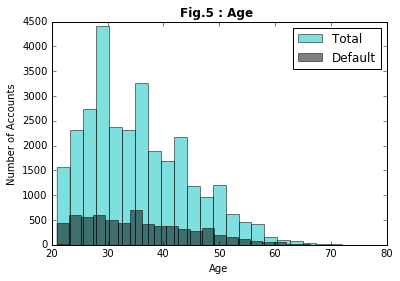

In [7]:
# Age (Feature name :'AGE' )
bins = 25

plt.hist(data['AGE'],bins = bins, color='c',label = 'Total',alpha=0.5)
plt.hist(data['AGE'][data['default.payment.next.month']==1], bins = bins, color='k',label = 'Default',alpha=0.5)

plt.xlabel('Age'); plt.ylabel('Number of Accounts')
plt.title('Fig.5 : Age ',fontweight="bold", size=12)
plt.legend();plt.show()

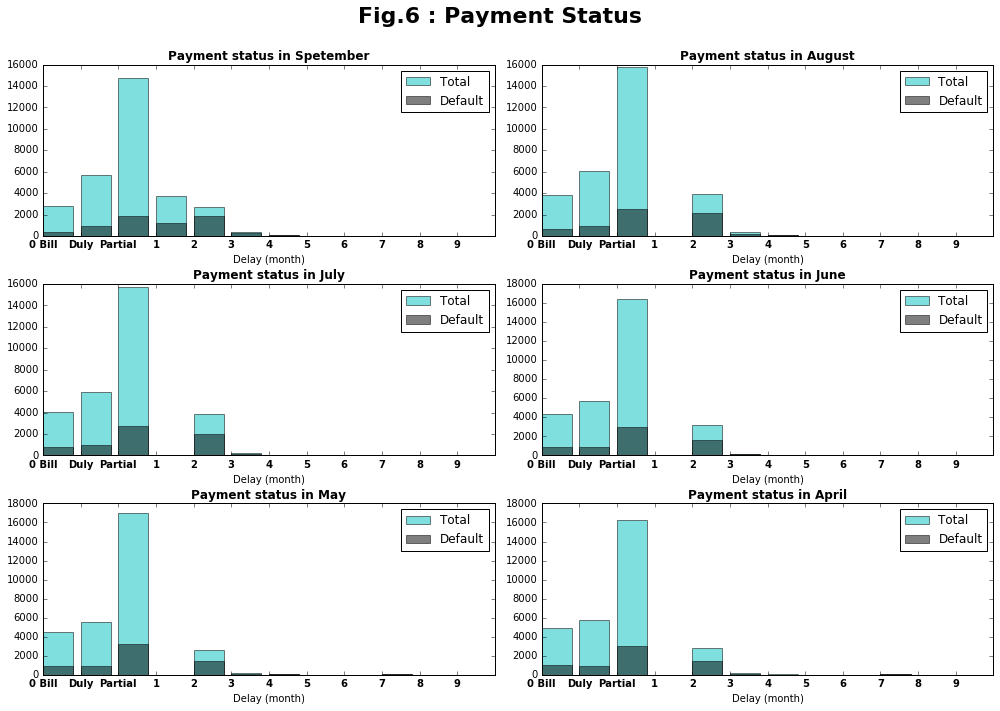

In [8]:
# Payment status (Feature name :'PAY_' )
import matplotlib.gridspec as gridspec
features = list(data.columns)
plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(3,2)
i = 0

plt.suptitle('Fig.6 : Payment Status',fontweight="bold", fontsize=22)
for cn in features[6:12]:
    ax = plt.subplot(gs[i])
    delay = np.zeros(12)
    delay_default = np.zeros(12)  
    for j in np.arange(0,12):
            delay[j] = data[cn][data[cn]==j-2].count()
            delay_default[j] = data[cn][(data[cn]==j-2)&(data['default.payment.next.month']==1)].count()  

    month = [-2,-1,0,1,2,3,4,5,6,7,8,9]
    plt.bar(month,delay, color='c',alpha=0.5, label='Total')
    plt.bar(month,delay_default, color='k',alpha=0.5, label='Default')

    plt.xticks([-2,-1,0,1,2,3,4,5,6,7,8,9],['0 Bill','Duly','Partial','1','2','3','4','5','6','7','8','9'], fontweight="bold", size=10)
    ax.set_xlabel('Delay (month)')
    months = ['Spetember','August','July','June','May','April']
    ax.set_title('Payment status in ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

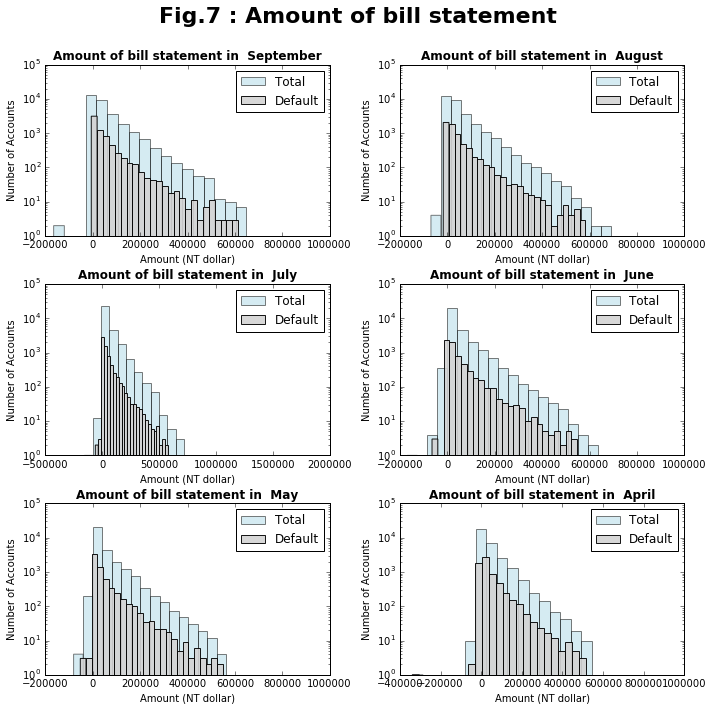

In [9]:
# Amount of bill statement (Feature name :'BILL_AMT_' )

features = list(data.columns)
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,2)
i = 0
plt.suptitle('Fig.7 : Amount of bill statement',fontweight="bold", fontsize=22)
for cn in features[12:18]:
    ax = plt.subplot(gs[i])
    bins = 25
    plt.hist(data[cn],bins = bins, color='lightblue',label = 'Total',alpha=0.5)
    plt.hist(data[cn][data['default.payment.next.month']==1], bins = bins, color='lightgray',label = 'Default',alpha=0.9)

    plt.xlabel('Amount (NT dollar)')
    plt.ylabel('Number of Accounts')
    ax.set_yscale('log', nonposy='clip')

    months = ['September','August','July','June','May','April']
    ax.set_title('Amount of bill statement in  ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1  
    plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

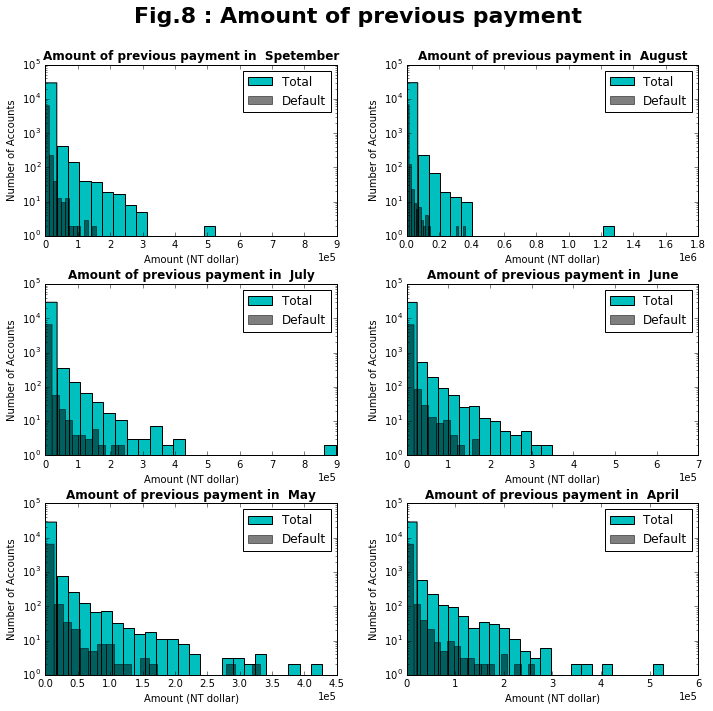

In [10]:
# Amount of previous payment (Feature name :'PAY_AMT_' )
features = list(data.columns)
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,2)
i = 0
plt.suptitle('Fig.8 : Amount of previous payment',fontweight="bold", fontsize=22)
for cn in features[18:24]:
    ax = plt.subplot(gs[i])
    bins = 25
    plt.hist(data[cn],bins = bins, color='c',label = 'Total',alpha=1)
    plt.hist(data[cn][data['default.payment.next.month']==1], bins = bins, color='k',label = 'Default',alpha=0.5)

    plt.xlabel('Amount (NT dollar)')
    plt.ylabel('Number of Accounts')
    ax.set_yscale('log', nonposy='clip')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    months = ['Spetember','August','July','June','May','April']
    ax.set_title('Amount of previous payment in  ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1      
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

### 3- Gaussian Naive Bayes (scikit library)

------------------------------------------
----- Gaussian Naive Bayes results -----
------------------------------------------

Classification accuracy is : 37.5757575758 %
Null accuracy is : 77.4747474747 %
Classification error is : 62.4242424242 %
Sensitivity is : 88.9237668161 %


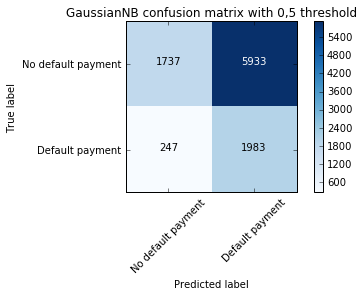

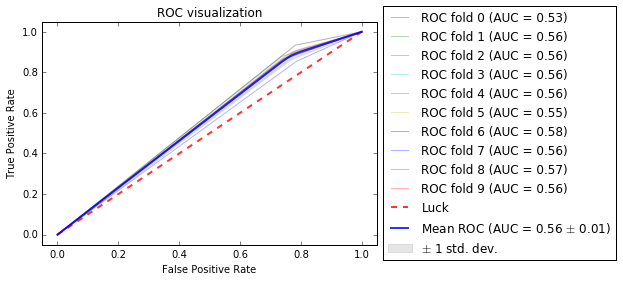

Classification accuracy is : 60.101010101 %
Null accuracy is : 77.4747474747 %
Classification error is : 39.898989899 %
Sensitivity is : 65.067264574 %


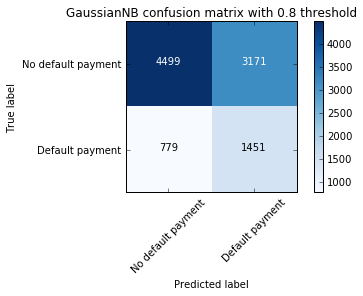

Classification accuracy is : 30.8585858586 %
Null accuracy is : 77.4747474747 %
Classification error is : 69.1414141414 %
Sensitivity is : 94.5291479821 %


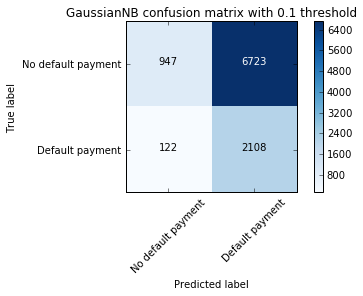

Classification accuracy is : 39.101010101 %
Null accuracy is : 77.4747474747 %
Classification error is : 60.898989899 %
Sensitivity is : 86.9955156951 %


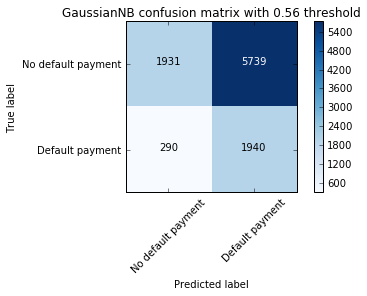




------------------------------------------
----- Bernouilli Naive Bayes results -----
------------------------------------------

Classification accuracy is : 77.0808080808 %
Null accuracy is : 77.4747474747 %
Classification error is : 22.9191919192 %
Sensitivity is : 49.6412556054 %


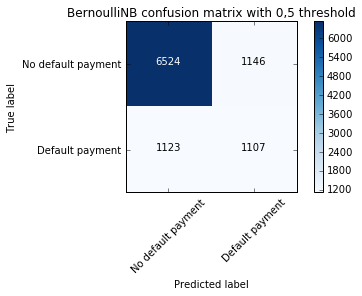

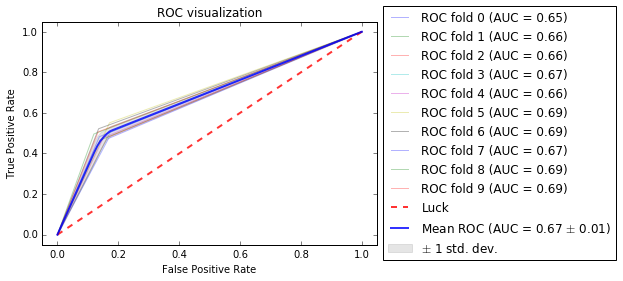

Classification accuracy is : 79.6262626263 %
Null accuracy is : 77.4747474747 %
Classification error is : 20.3737373737 %
Sensitivity is : 37.802690583 %


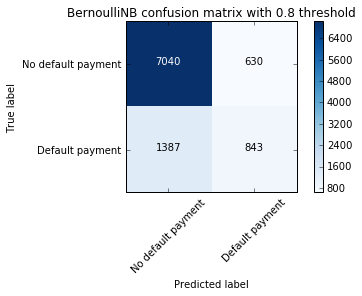

Classification accuracy is : 68.7171717172 %
Null accuracy is : 77.4747474747 %
Classification error is : 31.2828282828 %
Sensitivity is : 66.0986547085 %


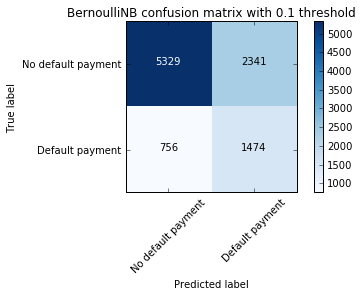

Classification accuracy is : 79.0909090909 %
Null accuracy is : 77.4747474747 %
Classification error is : 20.9090909091 %
Sensitivity is : 41.4798206278 %


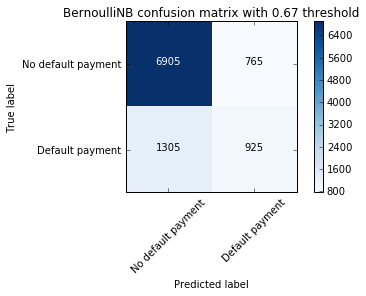

In [92]:
X = data.values[:,1:-1]
y = data.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)

#Note:prior are calculated based on the data.http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
clf_gaussian = GaussianNB()
clf_gaussian.fit(X_train, y_train)
y_predicted = clf_gaussian.predict(X_test)

print '------------------------------------------'
print '----- Gaussian Naive Bayes results -----'
print '------------------------------------------'
print ''
display_accuracy_analysis_and_confusion_matrix(y_test, y_predicted, 
                        ['No default payment', 'Default payment'], 'GaussianNB confusion matrix with 0,5 threshold')

display_roc(GaussianNB(), X, y)

# Testing other threshold than 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)
clf_gaussian2 = GaussianNB()
clf_gaussian2.fit(X_train, y_train)
y_predicted = clf_gaussian2.predict_proba(X_test)
y_test_predictions_high_precision = y_predicted[:,1] > 0.8
y_test_predictions_high_recall = y_predicted[:,1] > 0.1
y_test_predictions_suggested_by_AUC = y_predicted[:,1] > 0.56

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_precision, 
                        ['No default payment', 'Default payment'], 'GaussianNB confusion matrix with 0.8 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_recall, 
                        ['No default payment', 'Default payment'], 'GaussianNB confusion matrix with 0.1 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_suggested_by_AUC, 
                        ['No default payment', 'Default payment'], 'GaussianNB confusion matrix with 0.56 threshold')

print ''
print ''
print ''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)

clf_bernouilli = BernoulliNB()
clf_bernouilli.fit(X_train, y_train)
y_pred = clf_bernouilli.predict(X_test)

print '------------------------------------------'
print '----- Bernouilli Naive Bayes results -----'
print '------------------------------------------'
print ''

display_accuracy_analysis_and_confusion_matrix(y_test, y_pred, 
                        ['No default payment', 'Default payment'], 'BernoulliNB confusion matrix with 0,5 threshold')

display_roc(BernoulliNB(), X, y)

# Testing other threshold than 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)
clf_bernouilli2 = BernoulliNB()
clf_bernouilli2.fit(X_train, y_train)
y_predicted = clf_bernouilli2.predict_proba(X_test)
y_test_predictions_high_precision = y_predicted[:,1] > 0.8
y_test_predictions_high_recall = y_predicted[:,1] > 0.1
y_test_predictions_suggested_by_AUC = y_predicted[:,1] > 0.67

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_precision, 
                        ['No default payment', 'Default payment'], 'BernoulliNB confusion matrix with 0.8 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_recall, 
                        ['No default payment', 'Default payment'], 'BernoulliNB confusion matrix with 0.1 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_suggested_by_AUC, 
                        ['No default payment', 'Default payment'], 'BernoulliNB confusion matrix with 0.67 threshold')



## Results Analysis

### Gaussian Naive Bayes Analysis

The model accuracy is very low, only 37,57 %.
If the model had always guessed the most representative class (No default payment) he will have a 77,47% accuracy.
From the confusion matrix we can see that the model predicted 5933 default payment who were in fact non defaulted.
(TODO : search why the model made such prediction ? Doesnt make sense at first glance .... maybe an error somewhere with the prior ?)

From the confusion matrix, it's possible to get several metrics (Precision, Specificity, Sensitivity, etc..)
Since our business objective is to check whether a payment is defaulted or not, the metrics we should focus on is Sensitivity.
Sensitivity allow us to know how often the prediction for a default payment is correct.
A classification error for a true non-default payment is more acceptable than the other way around. (it's better for the enterprise to think that a payment will be defaulted and that it will not be at the end, rather than thinking that a payment will not be defaulted but it will be at the end)

Decreasing the threshold will increase the sensitivity (because it will be easier to predict the defaulted payment class)

The more the threshold is high, the more we gain in accuracy. It is the expected behaviour since our data is highly imbalance. Favoriting the non default payment class rather than the default one will reduce the number of error since we have a higher chance that the payment is not a default one.

To avoid this issue, we should put some weights on the default payment since we really want to detect them. We prefer flag a non default payment as a default payment rather than the opposite. 

TODO : as suggested by Philippe Lacaille, balance the data (50% default 50% non default)

TODO : put some weights on the default payments ?


### Bernouilli Naive Bayes Analysis
TODO


### Conclusion
TODO : why Bernouilli perform better than the gaussian ?
TODO : are we overfitting, specially with Bernouilli distribution and due to the inbalanced data ?
TODO : are we gonna be okay with generalization ?



## Utility functions and classes

In [80]:
# source : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def display_roc(classifier, X, y, number_of_fold=10):
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=10)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i=0
    for train, test in cv.split(X,y):
        classifier.fit(X[train], y[train])
        y_predicted = classifier.predict(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], y_predicted)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC visualization')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def display_accuracy_analysis_and_confusion_matrix(y_test, y_predicted, classes_name, confusion_matrix_title):
    # # Classification accuracy -> how often the classifier is correct
    print 'Classification accuracy is :', metrics.accuracy_score(y_test, y_predicted, normalize = True) * 100, '%'
    # # Calculate null accuracy for binary classification problems coded as 0 and 1.
    # # Null accuracy : accuracy that could be achieved by always predicting the most frequent class
    print 'Null accuracy is :', max(y_test.mean(), 1 - y_test.mean()) * 100, '%'
    # # Classification error -> how often the classifier is incorrect
    print 'Classification error is :', (1- metrics.accuracy_score(y_test, y_predicted, normalize = True)) * 100, '%'
    # # When the actual value is positive (1 -> default), how often the prediction is correct ?
    print 'Sensitivity is :', metrics.recall_score(y_test, y_predicted) * 100, '%'
    # # Confusion matrix (2x2 matrix since there is 2 response classes) TPR (True Positive Rate) FPR (False Positive Rate)
    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
    plot_confusion_matrix(confusion_matrix, classes=classes_name, normalize=False, title=confusion_matrix_title)
    plt.show()

# Gaussian Naive Bayes - Credit Card Fraud Dataset

### 1- Basic informations on data

In [97]:
## IMPORTING DATASET ##
## source: https://www.kaggle.com/dalpozz/creditcardfraud ##
data_credit_card_fraud = pandas.read_csv('creditcard.csv')

print('------ Basic informations on dataset ------')
data_credit_card_fraud['Class'].value_counts() # ouput number of 0 class and number of 1 class
data_credit_card_fraud.info()
# print data.describe()

------ Basic informations on dataset ------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null flo

### 2- Visual Exploratory Data Analysis

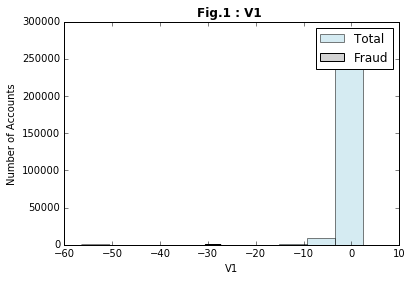

In [14]:
# V1
bins = 10
plt.hist(data_credit_card_fraud.V1, bins = bins, color='lightblue',label = 'Total',alpha=0.5)
plt.hist(data_credit_card_fraud.V1[data_credit_card_fraud['Class'] == 1], bins = bins, color='lightgray',label = 'Fraud')

plt.xlabel('V1');plt.ylabel('Number of Accounts')
plt.title('Fig.1 : V1 ',fontweight="bold", size=12)
plt.legend();plt.show()

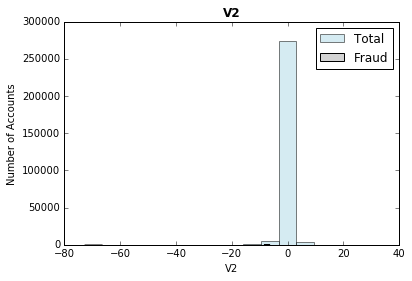

In [15]:
# V2
bins = 15
plt.hist(data_credit_card_fraud.V2, bins = bins, color='lightblue',label = 'Total',alpha=0.5)
plt.hist(data_credit_card_fraud.V2[data_credit_card_fraud['Class'] == 1], bins = bins, color='lightgray',label = 'Fraud')

plt.xlabel('V2');plt.ylabel('Number of Accounts')
plt.title('V2',fontweight="bold", size=12)
plt.legend();plt.show()

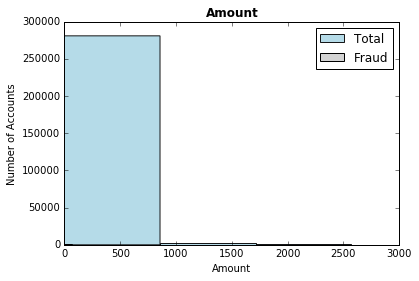

In [16]:
# Amount
bins = 30
plt.hist(data_credit_card_fraud.Amount, bins = bins, color='lightblue',label = 'Total',alpha=0.9)
plt.hist(data_credit_card_fraud.Amount[data_credit_card_fraud['Class'] == 1], bins = bins, color='lightgray',label = 'Fraud')

plt.xlabel('Amount');plt.ylabel('Number of Accounts')
plt.title('Amount',fontweight="bold", size=12)
axes = plt.gca()
axes.set_xlim([0,3000])
plt.legend();plt.show()

### 3- Gaussian Naive Bayes (scikit library)

 ------------------------------------------
----- Gaussian Naive Bayes results -----
------------------------------------------

Classification accuracy is : 97.7794801409 %
Null accuracy is : 99.8286997138 %
Classification error is : 2.22051985913 %
Sensitivity is : 84.4720496894 %


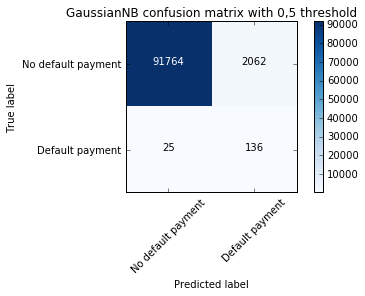

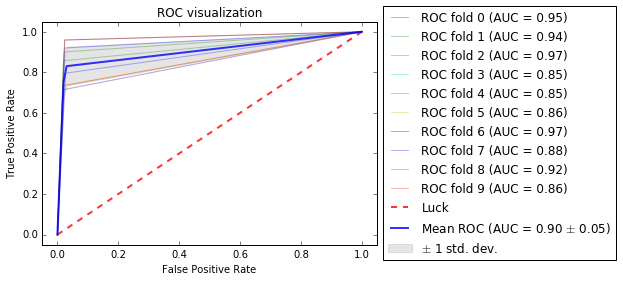

Classification accuracy is : 97.8539585262 %
Null accuracy is : 99.8286997138 %
Classification error is : 2.14604147382 %
Sensitivity is : 84.4720496894 %


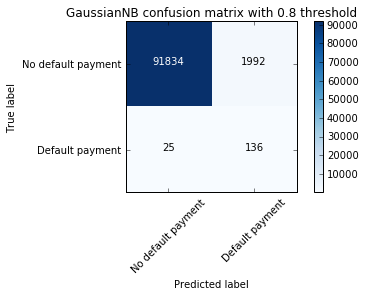

Classification accuracy is : 97.6613787013 %
Null accuracy is : 99.8286997138 %
Classification error is : 2.33862129869 %
Sensitivity is : 84.4720496894 %


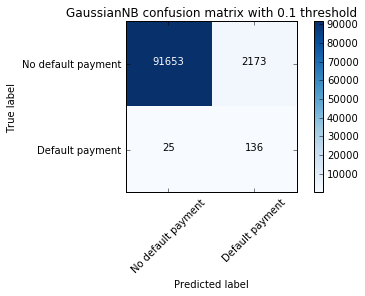

Classification accuracy is : 97.8911977188 %
Null accuracy is : 99.8286997138 %
Classification error is : 2.10880228117 %
Sensitivity is : 84.4720496894 %


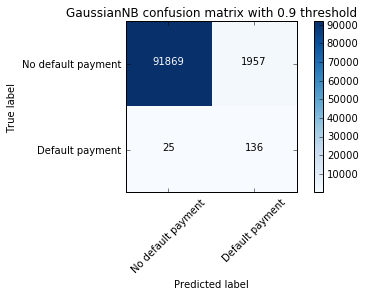




------------------------------------------
----- Bernouilli Naive Bayes results -----
------------------------------------------

Classification accuracy is : 99.9276495686 %
Null accuracy is : 99.8286997138 %
Classification error is : 0.0723504314426 %
Sensitivity is : 66.4596273292 %


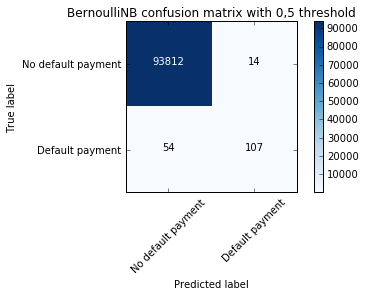

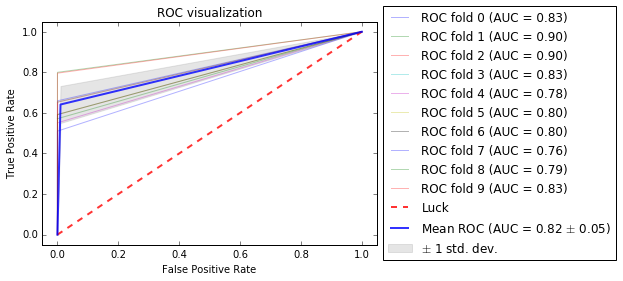

Classification accuracy is : 99.904242076 %
Null accuracy is : 99.8286997138 %
Classification error is : 0.0957579239682 %
Sensitivity is : 50.3105590062 %


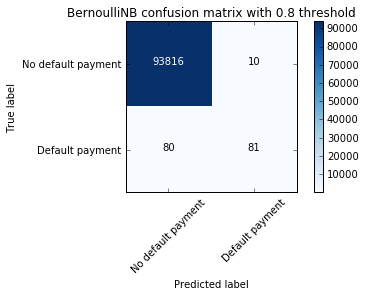

Classification accuracy is : 99.9265855916 %
Null accuracy is : 99.8286997138 %
Classification error is : 0.0734144083756 %
Sensitivity is : 80.7453416149 %


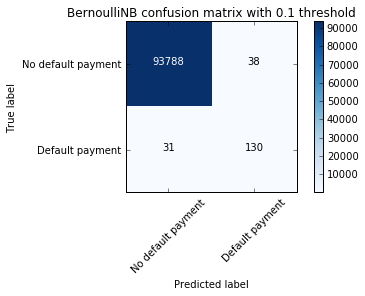

Classification accuracy is : 99.9191377531 %
Null accuracy is : 99.8286997138 %
Classification error is : 0.0808622469065 %
Sensitivity is : 60.248447205 %


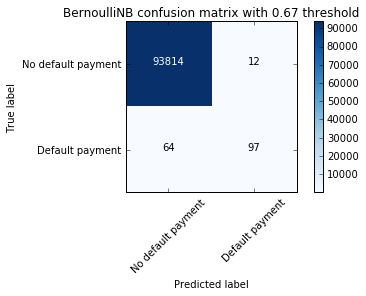

In [95]:
X = data_credit_card_fraud.values[:,1:-1]
y = data_credit_card_fraud.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)

clf_gaussian = GaussianNB()
clf_gaussian.fit(X_train, y_train)
y_predicted = clf_gaussian.predict(X_test)

print '------------------------------------------'
print '----- Gaussian Naive Bayes results -----'
print '------------------------------------------'
print ''
display_accuracy_analysis_and_confusion_matrix(y_test, y_predicted, 
                        ['No default payment', 'Default payment'], 'GaussianNB confusion matrix with 0,5 threshold')

display_roc(GaussianNB(), X, y)

# Testing other threshold than 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)
clf_gaussian2 = GaussianNB()
clf_gaussian2.fit(X_train, y_train)
y_predicted = clf_gaussian2.predict_proba(X_test)
y_test_predictions_high_precision = y_predicted[:,1] > 0.8
y_test_predictions_high_recall = y_predicted[:,1] > 0.1
y_test_predictions_suggested_by_AUC = y_predicted[:,1] > 0.9

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_precision, 
                        ['No default payment', 'Default payment'], 'GaussianNB confusion matrix with 0.8 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_recall, 
                        ['No default payment', 'Default payment'], 'GaussianNB confusion matrix with 0.1 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_suggested_by_AUC, 
                        ['No default payment', 'Default payment'], 'GaussianNB confusion matrix with 0.9 threshold')

print ''
print ''
print ''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)

clf_bernouilli = BernoulliNB()
clf_bernouilli.fit(X_train, y_train)
y_pred = clf_bernouilli.predict(X_test)

print '------------------------------------------'
print '----- Bernouilli Naive Bayes results -----'
print '------------------------------------------'
print ''

display_accuracy_analysis_and_confusion_matrix(y_test, y_pred, 
                        ['No default payment', 'Default payment'], 'BernoulliNB confusion matrix with 0,5 threshold')

display_roc(BernoulliNB(), X, y)

# Testing other threshold than 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)
clf_bernouilli2 = BernoulliNB()
clf_bernouilli2.fit(X_train, y_train)
y_predicted = clf_bernouilli2.predict_proba(X_test)
y_test_predictions_high_precision = y_predicted[:,1] > 0.8
y_test_predictions_high_recall = y_predicted[:,1] > 0.1
y_test_predictions_suggested_by_AUC = y_predicted[:,1] > 0.67

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_precision, 
                        ['No default payment', 'Default payment'], 'BernoulliNB confusion matrix with 0.8 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_high_recall, 
                        ['No default payment', 'Default payment'], 'BernoulliNB confusion matrix with 0.1 threshold')

display_accuracy_analysis_and_confusion_matrix(y_test, y_test_predictions_suggested_by_AUC, 
                        ['No default payment', 'Default payment'], 'BernoulliNB confusion matrix with 0.67 threshold')

## Results Analysis

### Gaussian Naive Bayes Analysis
TODO

### Bernouilli Naive Bayes Analysis
TODO

### Conclusion
TODO


## IDEA FROM COMMENTS 
- throwing away some data to make the dataset more balanced. what is the impact ?
- does the default dataset contains information from the fraud one ? and vice versa ?
- mix default and fraud dataset and see how it affects performance (therefore having 4 classes : default, fraud, non default, non fraud)